In [1]:
import os
import xml.etree.ElementTree as ET
import logging
import sys
import warnings
import copy
from functools import reduce
from typing import List

import numpy as np
import torch as th
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import train_reviews_path, test_reviews_path, TEST_APPENDIX, word2vec_model_path, UNKNOWN_WORD, \
                parsed_reviews_dump_path, PROGRESSBAR_COLUMNS_NUM
from src.review import get_reviews, load_reviews, dump_reviews, reviews_dump_path
from src.preprocess.spell_check import spell_check, load_checked_reviews
from src.preprocess.dep_parse import parse_reviews, load_parsed_reviews, dump_parsed_reviews
from src.sentence.aspect.classifier import AspectClassifier as SentenceAspectClassifier
from src.utils.embedding import get_embeddings

seed = 42
np.random.seed(seed)
th.manual_seed(seed)
th.cuda.manual_seed(seed)
logging.basicConfig(level=logging.INFO)

In [2]:
word2vec = get_embeddings()

train_reviews = load_parsed_reviews(file_pathway=parsed_reviews_dump_path)
train_sentences = [x for x in reduce(lambda x, y: x + y, train_reviews)]

test_reviews = load_parsed_reviews(file_pathway=parsed_reviews_dump_path + TEST_APPENDIX)
test_sentences = [x for x in reduce(lambda x, y: x + y, test_reviews)]

INFO:gensim.models.utils_any2vec:loading projection weights from /home/dmitry/Projects/absa/embeddings/tayga_upos_skipgram_300_2_2019/model.bin
INFO:gensim.models.utils_any2vec:loaded (249565, 300) matrix from /home/dmitry/Projects/absa/embeddings/tayga_upos_skipgram_300_2_2019/model.bin
INFO:root:Upload dependency trees from dump.
INFO:root:Upload dependency trees from dump.


# Sentence Aspect Classification

### Train

In [3]:
num_epoch = 40

classifier = SentenceAspectClassifier(word2vec=word2vec)
train_f1_history, val_f1_history = classifier.fit(train_sentences=train_sentences, 
                                                  val_sentences=test_sentences,
                                                  num_epoch=num_epoch)

100%|███████████████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.32it/s]


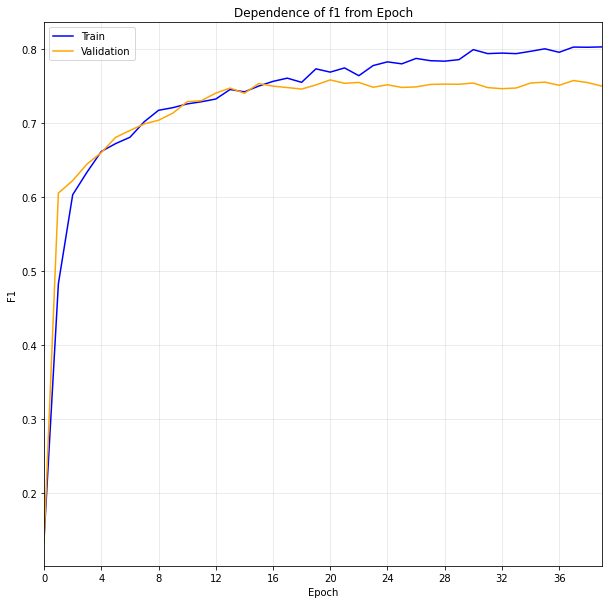

In [4]:
SCORE_NAME = 'f1'
PARAMETER_DECIMAL_LEN = 5
SCORE_DECIMAL_LEN = 3


def display_score(parameter_values: List,
                  train_values: List[float],
                  val_values: List[float],
                  parameter_name='Epoch',
                  score_name=SCORE_NAME) -> float:

    max_param, max_acc = [(parameter_values[index], val)
                          for index, val in enumerate(val_values) if val == max(val_values)][0]

    plt.figure(figsize=(10, 10))
    plt.grid(True, alpha=0.3)
    plt.xlim(left=min(parameter_values), right=max(parameter_values))

    # train
    plt.plot(parameter_values, train_values, color='blue')
    # validation
    plt.plot(parameter_values,
             val_values,
             color='orange')

    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(f'Dependence of {score_name} from {parameter_name}')
    plt.xlabel(f'{parameter_name}')
    plt.ylabel(score_name.capitalize())
    if isinstance(max_param, (int, )):
        plt.legend([
            f'Maximal {score_name}={max_acc:.{SCORE_DECIMAL_LEN}} when {parameter_name}={max_param}'
        ])
    else:
        plt.legend([
            f'Maximal {score_name}={max_acc:.{SCORE_DECIMAL_LEN}}' +
            f' when {parameter_name}={max_param:.{PARAMETER_DECIMAL_LEN}f}'
        ])
    plt.legend(['Train', 'Validation'])

display_score(parameter_values=[x for x in range(num_epoch)],
              train_values=train_f1_history,
              val_values=val_f1_history)

### Predict

In [5]:
test_sentences_pred = copy.deepcopy(test_sentences)
for sentence in test_sentences_pred:
    sentence.reset_targets()

test_sentences_pred = classifier.predict(test_sentences_pred)
classifier.score(sentences=test_sentences, sentences_pred=test_sentences_pred)

Score(precision=0.7370304114490162, recall=0.764378478664193, f1=0.7504553734061931)

# Target Aspect Classification